# Supporting Functions

In [1]:
def length_calculation(route, d):
  length = 0
  for i in range(len(route) - 1):
    length = length + d[route[i], route[i+1]]
  return length

def total_length_calculation(routes, d):
  total_length = 0
  for route in routes:
    total_length = total_length + length_calculation(route, d)
  return total_length

def route_demand_sum(route, demand):
  demand_sum = 0
  for i in route:
    demand_sum = demand_sum + demand[i]
  return demand_sum

def pheromone_evaporation(pheromone, evaporation_rate):
  for i in pheromone:
    pheromone[i] = (1 - evaporation_rate) * pheromone[i]

In [2]:
import numpy as np

def capacitated_routing_no_AFS(alpha, beta, V_cap, I, demand, pheromone, evaporation_rate, d):
  # ROUTING
  routes = list()
  vertices = I.copy()
  while (len(vertices) != 0):
    route = list()
    city = 0
    capacity = V_cap
    route.append(city)
    while (len(vertices) != 0):
      exp = lambda x: pheromone[city,x] ** alpha * (1/d[city,x]) ** beta
      probabilities = list(map(exp, vertices))
      probabilities = probabilities/np.sum(probabilities)
      city = np.random.choice(vertices, p=probabilities)
      capacity = capacity - demand[city]
      if (capacity > 0):
        route.append(city)
        vertices.remove(city)
      else:
        break
    route.append(0)
    routes.append(route)

  # TOTAL LENGTH CALCULATION
  total_length = total_length_calculation(routes, d)

  # NEW PHEROMONE
  for route in routes:
    for i in range(len(route) - 1):
      pheromone[route[i], route[i+1]] = pheromone[route[i], route[i+1]] + 50 / total_length

  result = (routes, total_length)

  return result

In [3]:
def add_one_AFS(best_result, fuel_tank, fuel_consumption_rate, d, F):
  max_length_without_refuel = fuel_tank / fuel_consumption_rate
  routes_with_AFS = list()
  for route in best_result[0]:
    temp_route = route.copy()
    min_route = None
    min_length = None
    for i in range(1, len(temp_route)):
      for afs in F:
        temp_route.insert(i, afs)
        route_to_AFS = 0
        for j in range(i):
          route_to_AFS = route_to_AFS + d[temp_route[j], temp_route[j+1]]
        if route_to_AFS < max_length_without_refuel:
          route_length = length_calculation(temp_route, d)
          if min_route:
            if min_length > route_length:
              min_route = temp_route.copy()
              min_length = route_length
          else:
            min_route = temp_route.copy()
            min_length = route_length
        temp_route.remove(afs)
    routes_with_AFS.append(min_route)

  total_length = 0
  for route in routes_with_AFS:
    for i in range(len(route) - 1):
      total_length = total_length + d[route[i], route[i+1]]

  best_result_with_AFS = (routes_with_AFS, total_length)
  return best_result_with_AFS

In [12]:
import matplotlib.pyplot as plt

def read_coordinate_data(filepath):
  x = list()
  y = list()
  f = open(filepath, 'r')
  for line in f:
    x.append(float(line.strip().split()[0]))
    y.append(float(line.strip().split()[1]))
  coordinates = [x, y]
  return coordinates

def print_graph(routes, coordinates, s):
  plt.scatter(coordinates[0][0], coordinates[1][0], c='red', label='Depot')
  plt.scatter(coordinates[0][1:-s], coordinates[1][1:-s], c='blue', label='Customer')
  plt.scatter(coordinates[0][-s:], coordinates[1][-s:], c='green', label='Fuel Station')
  n = len(coordinates[0])
  for i in range(n):
    plt.annotate(i, (coordinates[0][i], coordinates[1][i]))
  for route in routes:
    x = list()
    y = list()
    for i in route:
      x.append(coordinates[0][i])
      y.append(coordinates[1][i])
    plt.plot(x, y)
  plt.legend()

# Main Function

In [5]:
import pandas as pd

def main_small():
  distance_data = pd.read_excel('small-matrix-distance.xlsx')
  distance_data.drop(distance_data.columns[0], axis=1, inplace=True)
  distance_data_small = distance_data.to_numpy()

  V_cap = 695
  fuel_tank = 75
  fuel_consumption_rate = 0.125

  n = 11  # Number of customers
  s = 1   # Number of AFSs
  I = [i for i in range(1, n + 1)]                # Set of customers
  F = [i for i in range(n + 1, n + s + 1)]        # Set of AFSs
  V = [0] + I + F                                 # Set of vertices
  E = [(i, j) for i in V for j in V if i != j]    # Set of edges
  d = {(i, j): distance_data_small[i][j] for i, j in E}           # Distance matrix
  demand = [0, 135, 120, 128, 109, 96, 101, 87, 112, 78, 107, 94, 0]  # Demand list
  pheromone = {(i, j): 0.2 for i, j in E}         # Pheromone matrix

  iterations = 1000
  alpha = 1
  beta = 1
  evaporation_rate = 0.25
  best_result = capacitated_routing_no_AFS(alpha, beta, V_cap, I, demand, pheromone, evaporation_rate, d)
  for i in range(iterations):
    if (i % 20 == 0):
      pheromone_evaporation(pheromone, evaporation_rate)
    result = capacitated_routing_no_AFS(alpha, beta, V_cap, I, demand, pheromone, evaporation_rate, d)
    if result[1] < best_result[1]:
      best_result = result
  final_result = add_one_AFS(best_result, fuel_tank, fuel_consumption_rate, d, F)

  print('Optimal Solution after {0} iterations:'.format(iterations))
  print('There are {0} routes in the optimal solution:'.format(len(final_result[0])))
  for route in final_result[0]:
    print('\t', route, 'Length = {0}, Total Demand = {1}'.format(
        length_calculation(route, d), route_demand_sum(route, demand)))
  print('\tTotal length: {0}'.format(final_result[1]))

  #print_graph(final_result[0], read_coordinate_data('small-coordinates.txt'), s)

In [6]:
main_small()

Optimal Solution after 1000 iterations:
There are 2 routes in the optimal solution:
	 [0, 5, 12, 4, 1, 9, 6, 10, 0] Length = 622.5, Total Demand = 626
	 [0, 8, 3, 12, 11, 7, 2, 0] Length = 645.0, Total Demand = 541
	Total length: 1267.5


In [7]:
import pandas as pd

def main_big():
  distance_data = pd.read_excel('big-matrix-distance.xlsx')
  distance_data.drop(distance_data.columns[0], axis=1, inplace=True)
  distance_data_big = distance_data.to_numpy()

  V_cap = 695
  fuel_tank = 75
  fuel_consumption_rate = 0.125

  n = 23  # Number of customers
  s = 2   # Number of AFSs
  I = [i for i in range(1, n + 1)]                # Set of customers
  F = [i for i in range(n + 1, n + s + 1)]        # Set of AFSs
  V = [0] + I + F                                 # Set of vertices
  E = [(i, j) for i in V for j in V if i != j]    # Set of edges
  d = {(i, j): distance_data_big[i][j] for i, j in E}           # Distance matrix
  demand = [0, 135, 120, 128, 109, 96, 101, 87, 112, 78, 107, 94, 72,
            88, 93, 103, 97, 107, 101, 110, 94, 91, 95, 87, 0, 0] # Demand list
  pheromone = {(i, j): 1 for i, j in E}         # Pheromone matrix

  iterations = 5000
  alpha = 1
  beta = 1
  evaporation_rate = 0.25
  best_result = capacitated_routing_no_AFS(alpha, beta, V_cap, I, demand, pheromone, evaporation_rate, d)
  for i in range(iterations):
    if (i % 20 == 0):
      pheromone_evaporation(pheromone, evaporation_rate)
    result = capacitated_routing_no_AFS(alpha, beta, V_cap, I, demand, pheromone, evaporation_rate, d)
    if result[1] < best_result[1]:
      best_result = result
  final_result = add_one_AFS(best_result, fuel_tank, fuel_consumption_rate, d, F)

  print('Optimal Solution after {0} iterations:'.format(iterations))
  print('There are {0} routes in the optimal solution:'.format(len(final_result[0])))
  for route in final_result[0]:
    print('\t', route, 'Length = {0}, Total Demand = {1}'.format(
        length_calculation(route, d), route_demand_sum(route, demand)))
  print('\tTotal length: {0}'.format(final_result[1]))

  print_graph(final_result[0], read_coordinate_data('big-coordinates.txt'), s)

Optimal Solution after 5000 iterations:
There are 4 routes in the optimal solution:
	 [0, 2, 3, 4, 1, 5, 24, 13, 0] Length = 624.3, Total Demand = 676
	 [0, 17, 15, 11, 16, 18, 20, 7, 24, 0] Length = 647.5, Total Demand = 683
	 [0, 8, 21, 22, 14, 24, 19, 9, 6, 0] Length = 644.0999999999999, Total Demand = 680
	 [0, 23, 10, 12, 24, 0] Length = 633.2, Total Demand = 266
	Total length: 2549.1


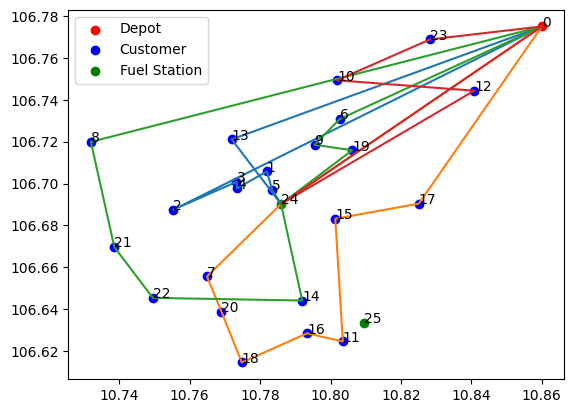

In [13]:
main_big()